# ポートフォリオ最適化

In [1]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance import QiskitFinanceError
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import *
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
register_matplotlib_converters()

In [2]:
# set number of assets (= number of qubits)
num_assets = 4

## ランダムな時系列データを用意

In [3]:
# # Generate expected return and covariance matrix from (random) time-series
# stocks = [("TICKER%s" % i) for i in range(num_assets)]
# data = RandomDataProvider(tickers=stocks,
#                  start=datetime.datetime(2016,1,1),
#                  end=datetime.datetime(2016,1,30))
# data.run()
# mu = data.get_period_return_mean_vector() # 平均期待リターン
# sigma = data.get_period_return_covariance_matrix() # 共分散行列

In [4]:
# print(mu)

In [5]:
# print(sigma)

In [6]:
# print("The underlying evolution of stock prices:")
# for (cnt, s) in enumerate(data._tickers):
#     plt.plot(data._data[cnt], label=s)
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

In [7]:
# for (cnt, s) in enumerate(data._tickers):
#     time_data = [(data._data[cnt][i] - data._data[cnt][i-1])/data._data[cnt][i-1] for i in range(1, len(data._data[cnt]))]
#     print(sum(time_data)/len(data._data[cnt]))

## 実際の時系列データを用いる

In [8]:
stocks = ["GOOG", "AAPL", "FB", "AMZN"]

token = "vAJEo2PRAm3tEsNQDyhk"
try:
    wiki = WikipediaDataProvider(
                        token = token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,1),
                        end = datetime.datetime(2016,1,30))
    wiki.run()
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

A return mean vector:
[ 0.00028658 -0.00400385  0.00606902 -0.0038914 ]
A covariance matrix:
[[269.60118129  25.42252332  66.36698713 300.34844591]
 [ 25.42252332   7.86304499   2.24515466  32.43615169]
 [ 66.36698713   2.24515466  24.44186199  63.44477427]
 [300.34844591  32.43615169  63.44477427 520.33363626]]


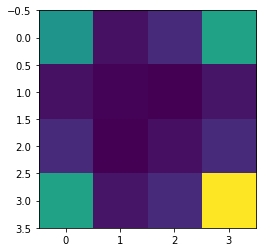

In [9]:
if wiki._data:
    if wiki._n <= 1:
        print("Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers.")
    else:
        mu = wiki.get_period_return_mean_vector()
        print("A return mean vector:")
        print(mu)

        sigma = wiki.get_covariance_matrix()
        print("A covariance matrix:")
        print(sigma)
        plt.imshow(sigma)
        plt.show()
else:
    print('No wiki data loaded.')

The underlying evolution of stock prices:


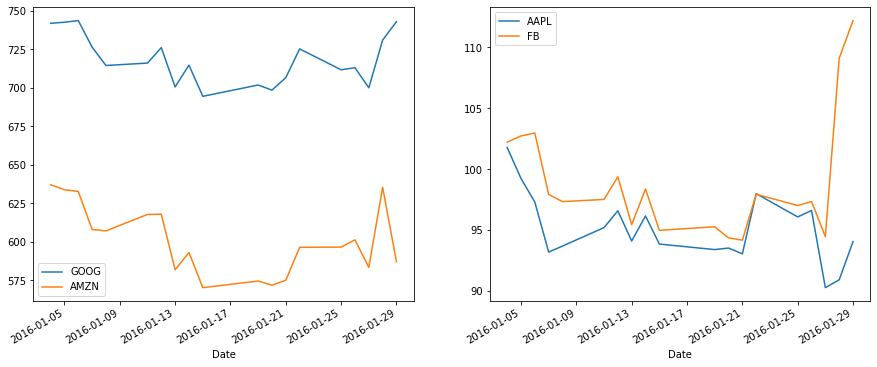

In [10]:
if wiki._data:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    print("The underlying evolution of stock prices:")
    for (cnt, s) in enumerate(stocks):
        axis = 0 if s in ("GOOG","AMZN")  else 1
        wiki._data[cnt].plot(ax=axes[axis], label=s, legend=True)
else:
    print('No wiki data loaded.')

In [11]:
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget (the number of assets to be selected out of n)
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [12]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    np.set_printoptions(formatter={'float': '{:.4f}'.format})
    print('Optimal: selection {}, value {}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [13]:
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result_classical = exact_eigensolver.run()

print_result(result_classical)

Optimal: selection [0 1 0 0], value 7.935526345268836

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	7.9355		1.0000
 [1 1 1 1]	917.3854		0.0000
 [0 1 1 1]	378.4472		0.0000
 [1 0 1 1]	841.3461		0.0000
 [0 0 1 1]	335.8303		0.0000
 [1 1 0 1]	761.1137		0.0000
 [0 1 0 1]	296.5424		0.0000
 [1 0 0 1]	695.3195		0.0000
 [0 0 0 1]	264.1707		0.0000
 [1 1 1 0]	248.9854		0.0000
 [0 1 1 0]	18.3955		0.0000
 [1 0 1 0]	213.3822		0.0000
 [0 0 1 0]	16.2149		0.0000
 [1 1 0 0]	164.1584		0.0000
 [1 0 0 0]	138.8003		0.0000
 [0 0 0 0]	16.0000		0.0000


In [14]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result_vqe = vqe.run(quantum_instance)

print_result(result_vqe)

Optimal: selection [0.0000 1.0000 0.0000 0.0000], value 7.935526345268836

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	7.9355		0.4290
 [0 0 1 0]	16.2149		0.3907
 [0 0 0 0]	16.0000		0.0982
 [0 1 1 0]	18.3955		0.0818
 [0 0 0 1]	264.1707		0.0001
 [1 1 0 0]	164.1584		0.0001
 [0 1 1 1]	378.4472		0.0000
 [1 0 1 0]	213.3822		0.0000
 [1 0 0 1]	695.3195		0.0000
 [0 0 1 1]	335.8303		0.0000
 [0 1 0 1]	296.5424		0.0000
 [1 1 1 1]	917.3854		0.0000
 [1 0 0 0]	138.8003		0.0000
 [1 0 1 1]	841.3461		0.0000
 [1 1 1 0]	248.9854		0.0000
 [1 1 0 1]	761.1137		0.0000


In [15]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result_qaoa = qaoa.run(quantum_instance)

print_result(result_qaoa)

Optimal: selection [1.0000 1.0000 1.0000 0.0000], value 248.9853575020819

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 1 0]	248.9854		0.1658
 [0 1 0 1]	296.5424		0.1551
 [0 0 0 1]	264.1707		0.1286
 [1 0 0 0]	138.8003		0.1055
 [0 1 0 0]	7.9355		0.0996
 [0 0 0 0]	16.0000		0.0638
 [1 1 0 0]	164.1584		0.0613
 [0 0 1 0]	16.2149		0.0479
 [0 1 1 1]	378.4472		0.0462
 [0 1 1 0]	18.3955		0.0382
 [0 0 1 1]	335.8303		0.0331
 [1 0 1 0]	213.3822		0.0319
 [1 0 1 1]	841.3461		0.0155
 [1 0 0 1]	695.3195		0.0033
 [1 1 0 1]	761.1137		0.0024
 [1 1 1 1]	917.3854		0.0017


# バックテスト

In [16]:
try:
    wiki = WikipediaDataProvider(
                        token = token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,31),
                        end = datetime.datetime(2016,12,31))
    wiki.run()
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

The underlying evolution of stock prices:


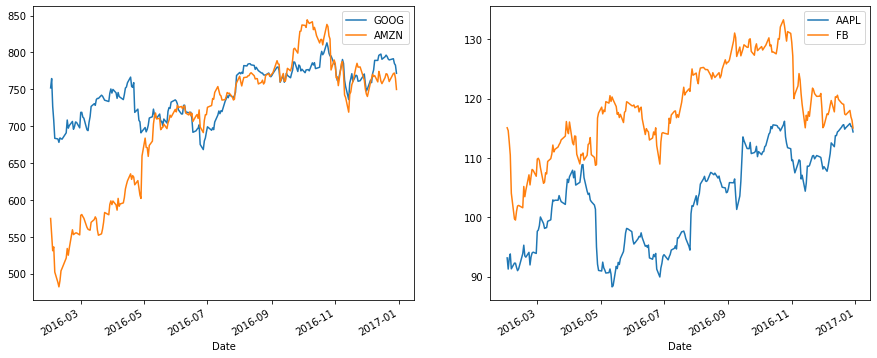

In [17]:
if wiki._data:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    print("The underlying evolution of stock prices:")
    for (cnt, s) in enumerate(stocks):
        axis = 0 if s in ("GOOG","AMZN")  else 1
        wiki._data[cnt].plot(ax=axes[axis], label=s, legend=True)
else:
    print('No wiki data loaded.')

In [20]:
selection_classical = sample_most_likely(result_classical.eigenstate)
selection_vqe = sample_most_likely(result_vqe.eigenstate)
selection_qaoa = sample_most_likely(result_qaoa.eigenstate)
selection_cheat = [0,0,0,1]

selection_all = {'classical':selection_classical, 'VQE':selection_vqe, 'QAOA':selection_qaoa, 'cheat':selection_cheat}

back test


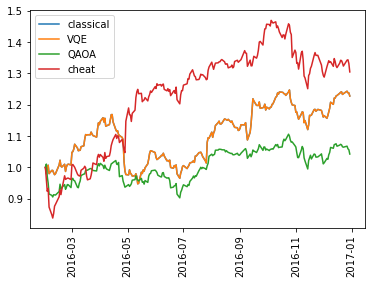

In [21]:
if wiki._data:
    print("back test")
    for label, selection in selection_all.items():
        total_price = 0
        initial_price = 0
        for (cnt, s) in enumerate(stocks):
            if selection[cnt] == 1:
                total_price += wiki._data[cnt]
                initial_price += wiki._data[cnt][0]
        plt.plot(total_price/initial_price, label=label)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
else:
    print('No wiki data loaded.')